In [1]:
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

c:\Users\mariu\OneDrive\Kurs\var24\bachelor47\gruppe47\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 4

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [3]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format,path):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        path=path,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    
    return ds

In [4]:
train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

AttributeError: in user code:

    File "C:\Users\mariu\AppData\Local\Temp\ipykernel_14672\2931096834.py", line 35, in None  *
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format)
    File "C:\Users\mariu\AppData\Local\Temp\ipykernel_14672\2931096834.py", line 20, in unpackage_raw_tfds_inputs  *
        boxes = keras_cv.bounding_box.convert_format(
    File "c:\Users\mariu\OneDrive\Kurs\var24\bachelor47\gruppe47\.venv\Lib\site-packages\keras_cv\src\backend\scope.py", line 304, in wrapper  *
        if keras_3() and keras.src.utils.backend_utils.in_tf_graph():

    AttributeError: module 'keras_cv.src.backend.keras' has no attribute 'src'


In [ ]:
eval_ds

<_BatchDataset element_spec={'images': RaggedTensorSpec(TensorShape([4, None, None, 3]), tf.uint8, 2, tf.int64), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.int64, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, 4]), tf.float32, 1, tf.int64)}}>

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2,path="train.png",
)

In [ ]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    path="eval.png",
)

In [ ]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

In [ ]:
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2, path="augmented.png"
)

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2, path="inference.png"
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

base_lr = 0.005

optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [ ]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

In [ ]:
#kan brukes ifølge stian
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    num_classes=20,
)



ValueError: Layer 'stem_1_conv' expected 1 variables, but received 0 variables during loading. Expected: ['stem_1_conv/kernel:0']

In [ ]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
    
)

ValueError: User metrics not yet supported for YOLOV8

model.fit(
    train_ds.take(20),
    epochs=10,
    callbacks=[coco_metrics_callback],
)

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format,path):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=False,
        font_scale=0.7,
        class_mapping=class_mapping,
        path=path
    )

In [ ]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.1,
    confidence_threshold=0.63,
)


In [ ]:
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh",path='detections.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step


In [ ]:
visualization_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32, name=None), {'boxes': TensorSpec(shape=(None, 32, 4), dtype=tf.float32, name=None), 'classes': TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)})>

In [ ]:
import os
notebook_path = os.path.abspath("selvtrent.ipynb")

In [ ]:
filepath = os.path.join(os.path.dirname(notebook_path), "frames/116.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

In [ ]:
image_batch = inference_resizing([image])

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


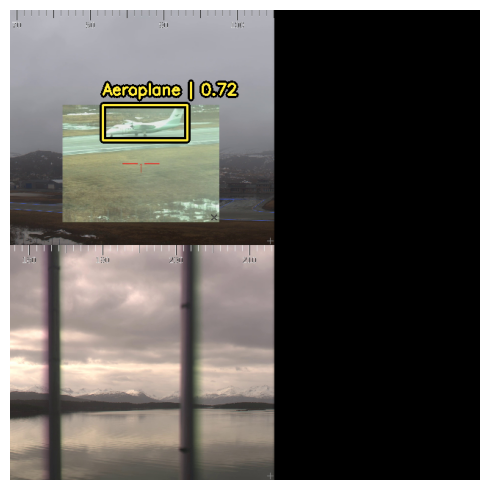

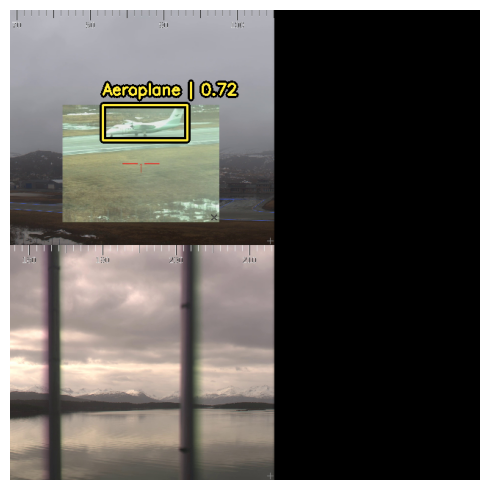

In [ ]:
y_pred = model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [ ]:
evaluation_result = model.evaluate(eval_ds.take(10),)

10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 1.1725


In [ ]:
print("Overall Evaluation Result:")
print(f"Total Loss: {evaluation_result}")

Overall Evaluation Result:
Total Loss: 1.1957939863204956
